In [1]:
#IMPORTING NECESSARY LIBRARIES
import os
import cv2
import time
import copy
import torch
import torchtext
import zipfile
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms, models
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
print(os.listdir())

['.DS_Store', 'requirements.txt', 'Makefile', 'COVID-19 Radiography Database', 'utils', 'models', 'README.md', 'requirements-dev.txt', '.gitignore', 'arch', '.ipynb_checkpoints', '.git', 'main.py', 'data', 'Main_Model.ipynb', '.idea']


In [13]:
DATA_PATH = './COVID-19 Radiography Database/'
RANDOM_SEED = 1
IMG_SIZE = (224, 224)
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [14]:
# preprocess the images (same dimensions, grayscale, normalized histogram)
input_shape = IMG_SIZE
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#Master dataset contains all the data with all labels
master_dataset = torchvision.datasets.ImageFolder(root = DATA_PATH, transform = data_transforms[TRAIN])

In [15]:
n = len(master_dataset)
print(n)
class_names = master_dataset.classes
class_names

2905


['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [16]:
# split
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - (2 * n_test)

train_set, val_set, test_set = torch.utils.data.random_split(master_dataset, (n_train, n_val, n_test))
print(f'No. of training data sample: {len(train_set)}')
print(f'No. of test data sample: {len(test_set)}')
print(f'No. of validation data sample: {len(val_set)}')

No. of training data sample: 1743
No. of test data sample: 581
No. of validation data sample: 581


In [17]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

In [18]:
training_dataloader = DataLoader(train_set, batch_size = 4, shuffle = True, num_workers = 0)
test_dataloader = DataLoader(test_set, batch_size = 4, shuffle=False)
val_dataloader = DataLoader(val_set, batch_size = 4, shuffle=False)

In [19]:
dataloaders = {TRAIN: training_dataloader, TEST: test_dataloader, VAL: val_dataloader}
dataset_sizes = {TRAIN: len(train_set), TEST: len(test_set), VAL: len(val_set)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NORMAL
Viral Pneumonia
Viral Pneumonia
NORMAL


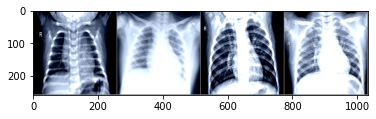

In [20]:
data_iter = iter(training_dataloader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images))
f = lambda l:class_names[l]
for label in labels.tolist():
    print(f(label))

In [81]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [89]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [91]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [92]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0/4
----------
train Loss: 0.4971 Acc: 0.8101


 20%|██        | 1/5 [09:50<39:22, 590.57s/it]

val Loss: 0.1737 Acc: 0.9346

Epoch 1/4
----------
train Loss: 0.3142 Acc: 0.8870


 40%|████      | 2/5 [19:23<29:15, 585.21s/it]

val Loss: 0.2282 Acc: 0.9053

Epoch 2/4
----------
train Loss: 0.2615 Acc: 0.9111


 60%|██████    | 3/5 [29:09<19:31, 585.63s/it]

val Loss: 0.0998 Acc: 0.9656

Epoch 3/4
----------
train Loss: 0.1306 Acc: 0.9518


 80%|████████  | 4/5 [39:02<09:47, 587.72s/it]

val Loss: 0.0646 Acc: 0.9759

Epoch 4/4
----------
train Loss: 0.0878 Acc: 0.9719


100%|██████████| 5/5 [48:36<00:00, 583.29s/it]

val Loss: 0.0581 Acc: 0.9828

Training complete in 48m 36s
Best val Acc: 0.982788


In [93]:
#SAVING THE MODEL WEIGHTS
torch.save(model_ft.state_dict(), './resnet_covid_weights.pickle')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


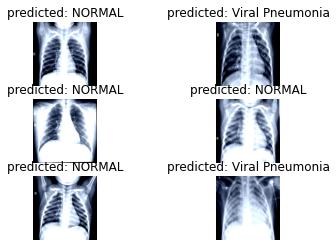

In [97]:
visualize_model(model_ft)

In [12]:
MODEL_PATH = './models/resnet_covid_weights.pickle'
#loading the pre-trained model

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [25]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
while images is not None and labels is not None:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print(predicted)

tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1, 1, 2])
tensor([1, 1,

KeyboardInterrupt: 